## <ol type="I"> <li> Neural discrete representation learning </li> </ol>


##### The goal of this project is to implement the paper Neural Discrete Representation Learning to understand how we can represent our latent space in a discrete manner.

#### First we will implement a Variational Autoencoder (VAE) that is trained on a concatenation of two datasets: MNIST (handwritten digits) and Fashion-MNIST (clothing items). The model will learn a latent representation that captures the distribution of both datasets, to see the limitation when we represent to different dataset with a continuous latent space, in the case of our VAE a gaussien distribution N(0 , I)

In [2]:
#Importation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

## II. Variational Autoencoder (VAE) 


### <span style="color:red"> Looking into the dataset</span>


In [3]:


####   loading the two dataset ####
transform = transforms.ToTensor() ### change the image to a tensor
mnist = datasets.MNIST(root="./data_0", train=True, download=True, transform=transform)
fashion_mnist = datasets.FashionMNIST(root="./data_0", train=True, download=True, transform=transform)


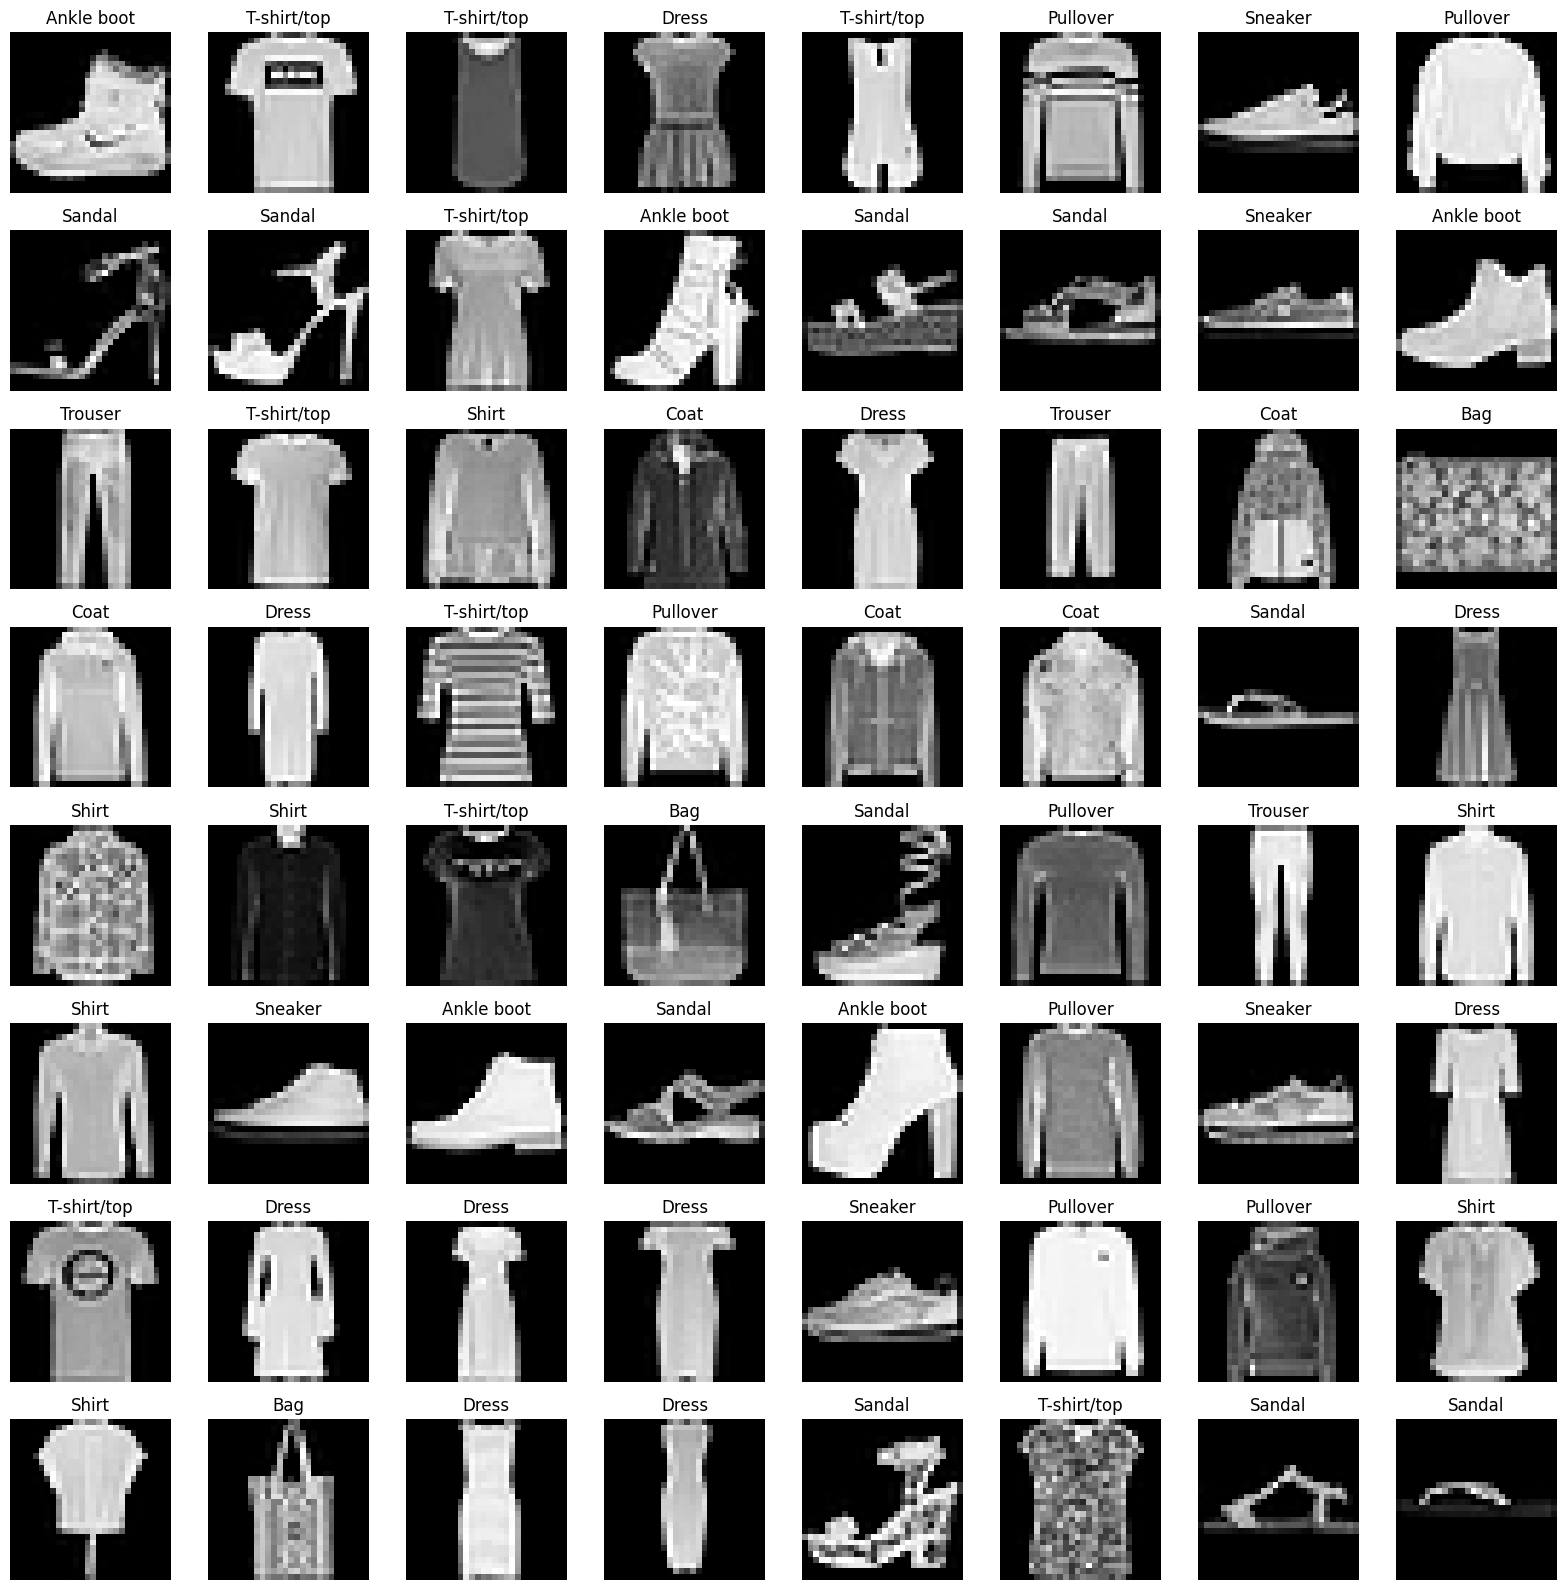

In [16]:
fig, axes = plt.subplots(8 , 8 , figsize = (16 , 16))
for i in range(64) :
    img , label = fashion_mnist[i]
    img = img.squeeze().numpy() ## transform to numpy array 

    row, col = divmod(i, 8)
    axes[row, col].imshow(img, cmap="gray")
    axes[row, col].set_title(fashion_mnist.classes[label])  
    axes[row, col].axis("off")  

plt.tight_layout()
plt.show()


In [20]:
#### lets see the distribution of lables 

dict_labels = {}
lenght = len(fashion_mnist)
for i in range(lenght) :
    img , label = fashion_mnist[i]
    if label in dict_labels.keys() : 
        dict_labels[label] += 1
    else : 
        dict_labels[label] = 1    

In [29]:
for label in dict_labels.keys() : 
    print(f" the number of {fashion_mnist.classes[label]} in the data set  is {dict_labels[label]}")

 the number of Ankle boot in the data set  is 6000
 the number of T-shirt/top in the data set  is 6000
 the number of Dress in the data set  is 6000
 the number of Pullover in the data set  is 6000
 the number of Sneaker in the data set  is 6000
 the number of Sandal in the data set  is 6000
 the number of Trouser in the data set  is 6000
 the number of Shirt in the data set  is 6000
 the number of Coat in the data set  is 6000
 the number of Bag in the data set  is 6000


#### The Fashion-MNIST dataset contains 10 classes: 'Ankle boot', 'T-shirt/top', 'Dress', 'Pullover', 'Sneaker', 'Sandal', 'Trouser', 'Shirt', 'Coat', and 'Bag', each with 6,000 samples.

### <span style="color:red">Concatenation of the two datasets</span>


In [34]:


img1 , _ = fashion_mnist[0]
img2, _  = mnist[0]

#### lets check if the two dataset has the same dimensions ####
print(img1.shape ,  img2.shape)


### check the type ####
print(type(img1) , type(img2))

### checks the labels ###

print(mnist.classes , fashion_mnist.classes)

### check the format of labels ###

print(mnist.targets , fashion_mnist.targets)

torch.Size([1, 28, 28]) torch.Size([1, 28, 28])
<class 'torch.Tensor'> <class 'torch.Tensor'>
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
tensor([5, 0, 4,  ..., 5, 6, 8]) tensor([9, 0, 0,  ..., 3, 0, 5])


In [35]:
### there is not much transformation that we should do to concatenate the datasets correctly we need  just to normalize using the same transformation and to translate the target in fashion mnist  #####


mnist_data = mnist.data.float() / 255.0
fashion_data = fashion_mnist.data.float() / 255.0


concat_data = torch.cat((mnist_data, fashion_data), dim=0).unsqueeze(1) 
concat_labels = torch.cat((mnist.targets, fashion_mnist.targets + 10), dim=0) 


### create the combined data set ####

dataset = TensorDataset(concat_data, concat_labels)


In [38]:
img , _  = dataset[0]
print(img.shape)

torch.Size([1, 28, 28])


### <span style="color:red">Theory</span>


### VAE class

In [ ]:
class VAE(nn.Module) : 
    def __init__(self , latent_dim = 20) : 
        super(VAE , self).__init__()
        self.latent_dim = latent_dim 

        ## Encoder 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # (14x14x32)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (7x7x64)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # (4x4x128)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4*4*128, 128),  # Adjusted input size to match 3 conv layers
            nn.ReLU()
        )


        ## Add tha layer to compute the mean and the ecart-type of the latent space 

        
        self.mu = nn.Linear(128, latent_dim)
        self.var = nn.Linear(128, latent_dim)
        
        ## Decoder
        self.decoder_cor = nn.Linear(latent_dim, 7*7*128)  
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1),  
            nn.Sigmoid()
        )

    def reparemetrise_trick(self , mu , var) : 
            std = torch.exp(0.5 * var)
            eps = torch.randn_like(std)
            return mu + eps*std
        
        ## def forward pass of our model
    def forward(self , x) : 
            x_encoded = self.encoder(x)
            ### get the latent representation 
            mu_x , var_x = self.mu(x_encoded) , self.var(x_encoded)
            z_latent = self.reparemetrise_trick(mu_x , var_x)
            z_latent_cor = self.decoder_cor(z_latent).view(-1, 128, 7, 7)
            x_recontructed = self.decoder(z_latent_cor)
            return x_recontructed , mu_x , var_x
    


## Loss function of our model 

In [69]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

## Train our VAE model

In [70]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
device = torch.device("cpu")
vae = VAE(latent_dim=20).to(device)
optimizer = optim.Adam(vae.parameters() , lr = 1e-4)



In [72]:
epochs = 40
vae.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x, _ = batch
        x = x.to(device)
        
        optimizer.zero_grad()
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss per Image: {total_loss / len(dataloader.dataset):.4f}")    

Epoch [1/40], Loss per Image: 182.3990
Epoch [2/40], Loss per Image: 181.6012
Epoch [3/40], Loss per Image: 180.8631
Epoch [4/40], Loss per Image: 180.2545
Epoch [5/40], Loss per Image: 179.7408
Epoch [6/40], Loss per Image: 179.2527
Epoch [7/40], Loss per Image: 178.8430
Epoch [8/40], Loss per Image: 178.4528
Epoch [9/40], Loss per Image: 178.1003
Epoch [10/40], Loss per Image: 177.7777
Epoch [11/40], Loss per Image: 177.4963
Epoch [12/40], Loss per Image: 177.2411
Epoch [13/40], Loss per Image: 176.9721
Epoch [14/40], Loss per Image: 176.7293
Epoch [15/40], Loss per Image: 176.5245
Epoch [16/40], Loss per Image: 176.2921
Epoch [17/40], Loss per Image: 176.0934
Epoch [18/40], Loss per Image: 175.9477
Epoch [19/40], Loss per Image: 175.7405
Epoch [20/40], Loss per Image: 175.5435
Epoch [21/40], Loss per Image: 175.4283
Epoch [22/40], Loss per Image: 175.2324
Epoch [23/40], Loss per Image: 175.1119
Epoch [24/40], Loss per Image: 174.9632
Epoch [25/40], Loss per Image: 174.8166
Epoch [26

In [73]:
torch.save(vae, "vae_model.pth")

### Samples

In [74]:
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=128, bias=True)
    (8): ReLU()
  )
  (mu): Linear(in_features=128, out_features=20, bias=True)
  (var): Linear(in_features=128, out_features=20, bias=True)
  (decoder_cor): Linear(in_features=20, out_features=6272, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Sigmoid()
  )
)

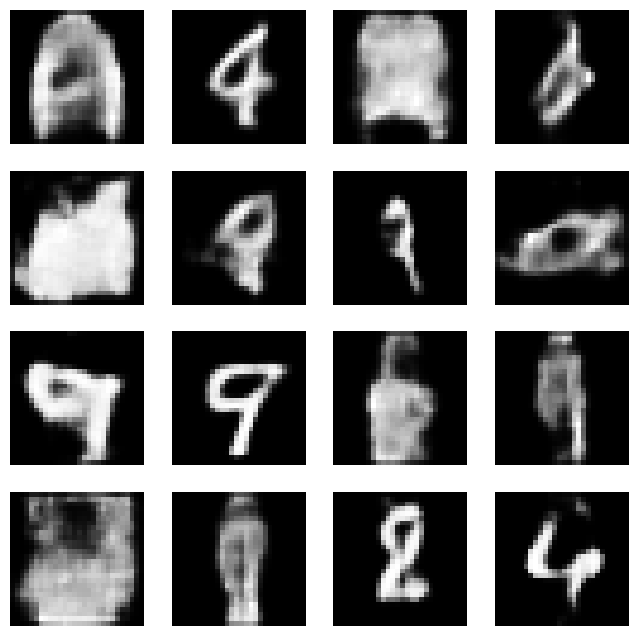

In [86]:
with torch.no_grad():
    z = torch.randn(16, 20).to(device)  # Random latent vectors
    samples = vae.decoder_cor(z).view(-1, 128, 7, 7)  # Correct reshaping for decoder input
    samples = vae.decoder(samples).cpu().numpy()

# Plot generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()


### As we can see the continuous representation of latent space give us  some strange samples, because the continuous representation isn't adequat in this cases, so the idea to look for a methode that represent the latent space in a discret manner.

## III- VQ-VAE

#### In this part we are going to implement the VQ-VAE as it described in the papaer

 #### VQ-VAE
 